In [1]:
import sys
sys.path.append('../src/')

from data_extraction import tools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import glob
import mne
import re
import os
import pickle
import seaborn as sns

In [4]:
path = '../data/SubjectX1/headcast_subj01_sess01_EEG_data_cube-epo.fif'
data = mne.read_epochs(path)

Reading ../data/SubjectX1/headcast_subj01_sess01_EEG_data_cube-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
327 matching events found
No baseline correction applied
327 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [5]:
data.info

<Info | 18 non-empty fields
    bads : list | 0 items
    ch_names : list | 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
    chs : list | 60 items (EEG: 60)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : NoneType | unspecified
    meas_id : dict | 4 items
    nchan : int | 60
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>

In [6]:
def saperate_passive_active(epoch_array):
    events = epoch_array.events
    data_array = epoch_array.get_data()
    
    data_shape = data_array.shape
    active_indexes = []
    passive_indexes = []
    for i in range(len(events)):
        if events[i][2] == 1:
            active_indexes.append(i)
        if events[i][2] == 2:
            passive_indexes.append(i)
            
    return data_array[active_indexes, :, :], data_array[passive_indexes, :, :]

def sample_data_points(data, gap=300):
    data_shape = data.shape
    sampling_indexes = [index for index in range(0, data_shape[2], gap)]
    sampled_data = data[:, :, sampling_indexes].transpose(1,2,0).reshape(data_shape[1], -1)
    return sampled_data

def create_dataset(filepaths, verbose=0):
    temp_active = None
    temp_passive = None
    for path in filepaths:
        epochs = mne.read_epochs(path, verbose=verbose)
        active, passive = saperate_passive_active(epochs)
        sampled_active = sample_data_points(active)
        sampled_passive = sample_data_points(passive)
        if (temp_active is not None) and (temp_passive is not None):
            temp_active = np.hstack([temp_active, sampled_active])
            temp_passive = np.hstack([temp_passive, sampled_passive])
        else:
            temp_active = sampled_active
            temp_passive = sampled_passive
        
    return temp_active, temp_passive
        
def create_m(edges, dim):
    m = np.zeros((dim,dim))
    for edge in edges:
        m[edge[0], edge[1]] = 1
    return m

def read_in_graphs_sparsities(path_to_output, event_type):
    paths = []
    event_name = ''
    if event_type == 1:
        event_name = "btn"
    elif event_type == 2:
        event_name = "auto"
        
    for i in range(10):
        path = path_to_output + event_name + str(i+1) + '.pkl'
        paths.append(path)
    
    graphs = []
    
    for path in paths:
        with open(path, 'rb') as f:
            result = pickle.load(f)
        m = create_m(result['graph'].edges(), 60)
        graphs.append(m)
    
    return graphs

def fold_graph(m):
    m_shape = m.shape
    m = np.round(m)
    m_copy = m.copy()
    for i in range(m_shape[0]):
        for j in range(m_shape[1]):
            if i > j:
                if (m[i][j] == 0) & (m[j][i] == 1):
                    m_copy[i][i] = 1
                    m_copy[j][i] = 0
                elif (m[i][j] == 1) & (m[j][i] == 1):
                    m_copy[j][i] = 0
                
            elif i == j:
                m_copy[i][j] = 0
    return m_copy
    
def generate_comparison_mx(corr, graph):
    graph_folded = fold_graph(graph)
    corr = np.triu(corr)
    comparison_mx = corr + graph_folded
    return comparison_mx

In [7]:
LEFT_CH = [1, 4, 5, 8, 9, 10, 11, 17, 18, 19, 20, 25, 26, 27, 28, 29, 36, 37, 38, 39, 44, 45, 46, 47, 53, 54, 57];

RIGHT_CH = [3, 7, 6, 16, 15, 14, 13, 24, 23, 22, 21, 35, 34, 33, 32, 31, 43, 42, 41, 40, 52, 51, 50, 49, 56, 55, 59];

VER_MID_CH = [2, 12, 30, 48, 58, 60];

In [8]:
indexes = np.array(LEFT_CH + RIGHT_CH + VER_MID_CH) - 1

In [9]:
chs = LEFT_CH + RIGHT_CH + VER_MID_CH

In [10]:
# Define the entire processing pipe line for a single subject
def process(data_mat, graphs_paths):
    # Get the active and passive data
    active, passive = create_dataset(data_mat)

    # Reorganize the dataset into the orders of the electrodes defined
    active = active[indexes]
    passive = passive[indexes]

    # Read in all the graphs for different sparsities
    
    graphs_active = read_in_graphs_sparsities(graphs_paths+"active/", 1)
    graphs_passive = read_in_graphs_sparsities(graphs_paths+"passive/", 2)

    # Calculate the correlation materix for active and passive 
    corr_active = np.corrcoef(active)
    corr_passive = np.corrcoef(passive)
    
    # Plot the 10 sparsities for active and passive and compare them with the correlation matrix
    plt.rcParams["figure.figsize"] = (30, 130)
    fig, axs = plt.subplots(10, 2)
    for i in range(len(graphs_active)):
        m_corr_active = generate_comparison_mx(corr_active, graphs_active[i])
        m_corr_passive = generate_comparison_mx(corr_passive, graphs_passive[i])
        sns.heatmap(m_corr_active, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-1, vmax=1, ax=axs[i,0])
        axs[i,0].set_title('Active: Sparsity ' + str(i+1))
        sns.heatmap(m_corr_passive, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-1, vmax=1, ax=axs[i,1])
        axs[i,1].set_title('Passive: Sparsity ' + str(i+1))
        
    graphs_active_freq = np.sum(np.array(graphs_active), axis=0)
    graphs_passive_freq = np.sum(np.array(graphs_passive), axis=0)
    
    # Comparing the frequency table of the active vs passive
    plt.rcParams["figure.figsize"] = (20, 8)
    fig, axs = plt.subplots(1, 2)
    sns.heatmap(graphs_active_freq, cmap='Blues', xticklabels=chs, yticklabels=chs, vmin=0, vmax=10, ax=axs[0])
    axs[0].set_title('Active Adjacency Frequency')
    sns.heatmap(graphs_passive_freq, cmap='Blues', xticklabels=chs, yticklabels=chs, vmin=0, vmax=10, ax=axs[1])
    axs[1].set_title('Passive Adjacency Frequency')
    
    graph_diff = graphs_active_freq - graphs_passive_freq
    plt.rcParams["figure.figsize"] = (12, 10)
    fig = plt.figure()
    sns.heatmap(graph_diff, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-10, vmax=10)

# SubjectX1

In [11]:
data_mat = sorted(glob.glob('../data/SubjectX1/*.fif'))
data_mat

['../data/SubjectX1/headcast_subj01_sess01_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess02_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess03_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess04_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess05_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess06_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess07_EEG_data_cube-epo.fif']

In [13]:
epochs = mne.read_epochs(path, verbose=0)
active, passive = saperate_passive_active(epochs)
n = active.shape

temp = np.zeros(corr.shape)
for i in range(n[0]):
    trial = active[:, indexes, :][i,:,:]
    corr = np.corrcoef(trial)
    temp = temp + corr
    
temp/n[0]

array([[ 1.        ,  0.80423149,  0.78408787, ..., -0.7865925 ,
        -0.70483654, -0.65349807],
       [ 0.80423149,  1.        ,  0.87812618, ..., -0.8683308 ,
        -0.8956663 , -0.85940674],
       [ 0.78408787,  0.87812618,  1.        , ..., -0.75300357,
        -0.74888027, -0.72977817],
       ...,
       [-0.7865925 , -0.8683308 , -0.75300357, ...,  1.        ,
         0.82650015,  0.69244376],
       [-0.70483654, -0.8956663 , -0.74888027, ...,  0.82650015,
         1.        ,  0.92926748],
       [-0.65349807, -0.85940674, -0.72977817, ...,  0.69244376,
         0.92926748,  1.        ]])

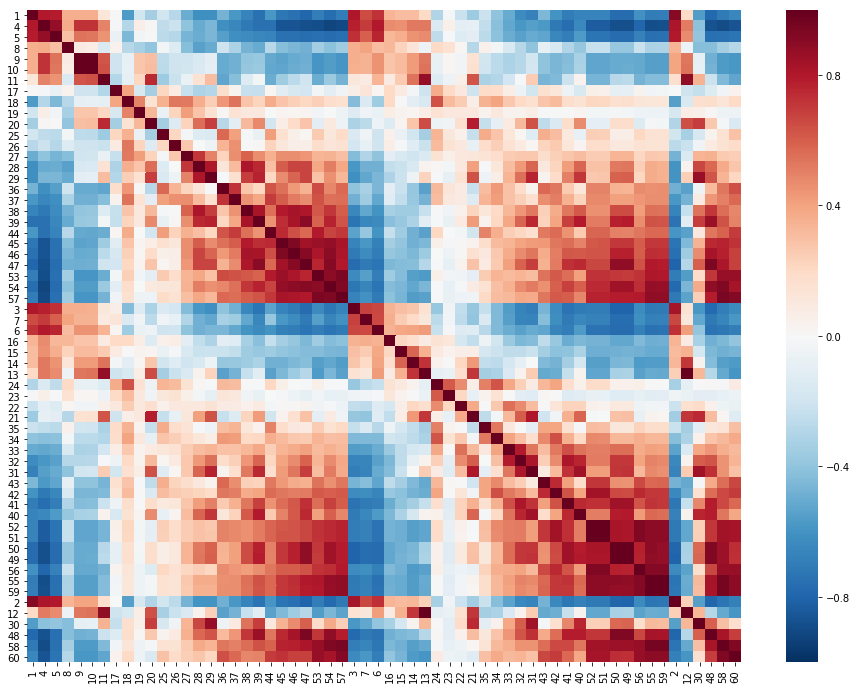

In [38]:
plt.rcParams["figure.figsize"] = (16, 12)
sns.heatmap(temp/171, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-1, vmax=1)

In [26]:
trial = active[:, indexes, :][0,:,:]

In [27]:
trial.shape

(60, 2001)

In [28]:
corr = np.corrcoef(trial)

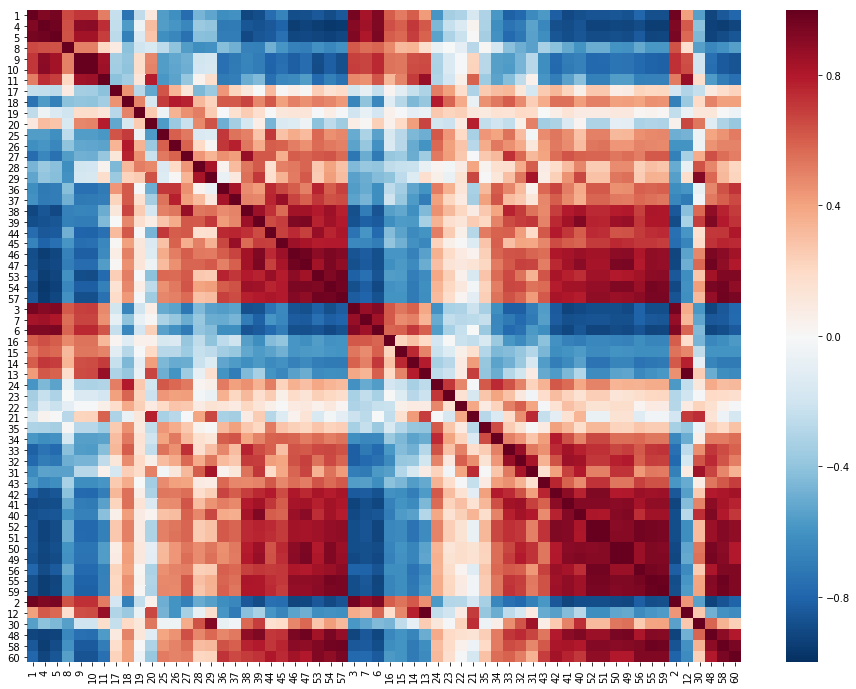

In [30]:
plt.rcParams["figure.figsize"] = (16, 12)
sns.heatmap(corr, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-1, vmax=1)

In [12]:
# Get the active and passive data
active, passive = create_dataset(data_mat)

# Reorganize the dataset into the orders of the electrodes defined
active = active[indexes]
passive = passive[indexes]

# Read in all the graphs for different sparsities
graphs_active = read_in_graphs_sparsities('../data/graphs/subject1/active/', 1)
graphs_passive = read_in_graphs_sparsities('../data/graphs/subject1/passive/', 2)

# Calculate the correlation materix for active and passive 
corr_active = np.corrcoef(active)
corr_passive = np.corrcoef(passive)

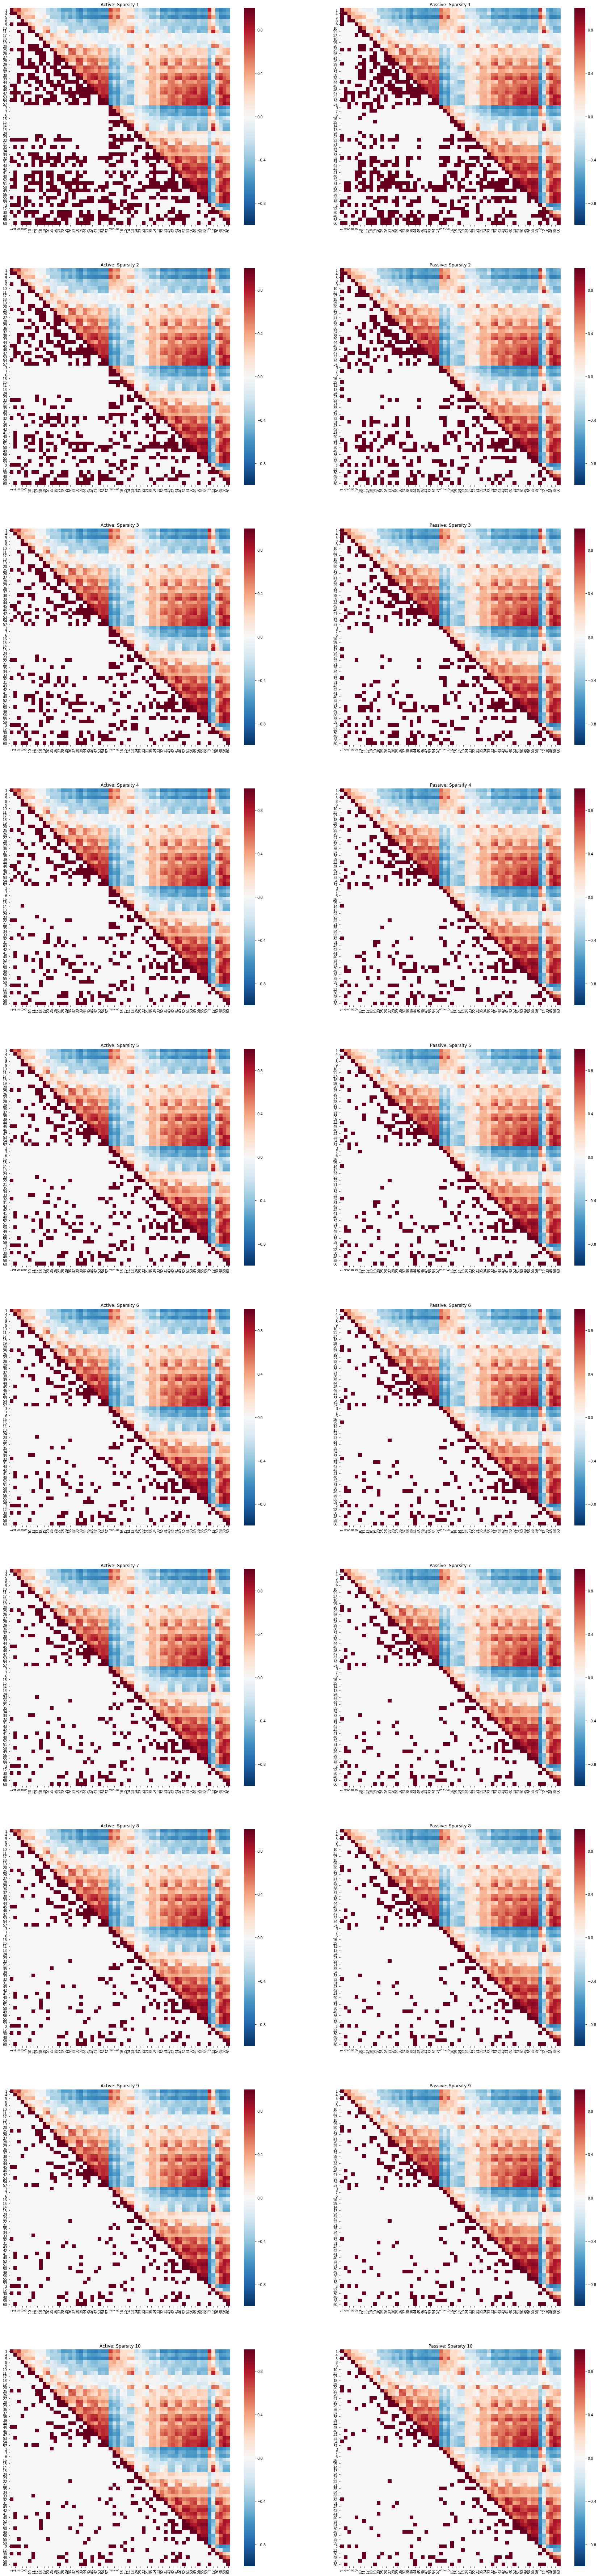

In [13]:
# Plot the 10 sparsities for active and passive and compare them with the correlation matrix
plt.rcParams["figure.figsize"] = (30, 130)
fig, axs = plt.subplots(10, 2)
for i in range(len(graphs_active)):
    m_corr_active = generate_comparison_mx(corr_active, graphs_active[i])
    m_corr_passive = generate_comparison_mx(corr_passive, graphs_passive[i])
    sns.heatmap(m_corr_active, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-1, vmax=1, ax=axs[i,0])
    axs[i,0].set_title('Active: Sparsity ' + str(i+1))
    sns.heatmap(m_corr_passive, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-1, vmax=1, ax=axs[i,1])
    axs[i,1].set_title('Passive: Sparsity ' + str(i+1))
        

In [14]:
graphs_active_freq = np.sum(np.array(graphs_active), axis=0)
graphs_passive_freq = np.sum(np.array(graphs_passive), axis=0)

Text(0.5, 1.0, 'Passive Adjacency Frequency')

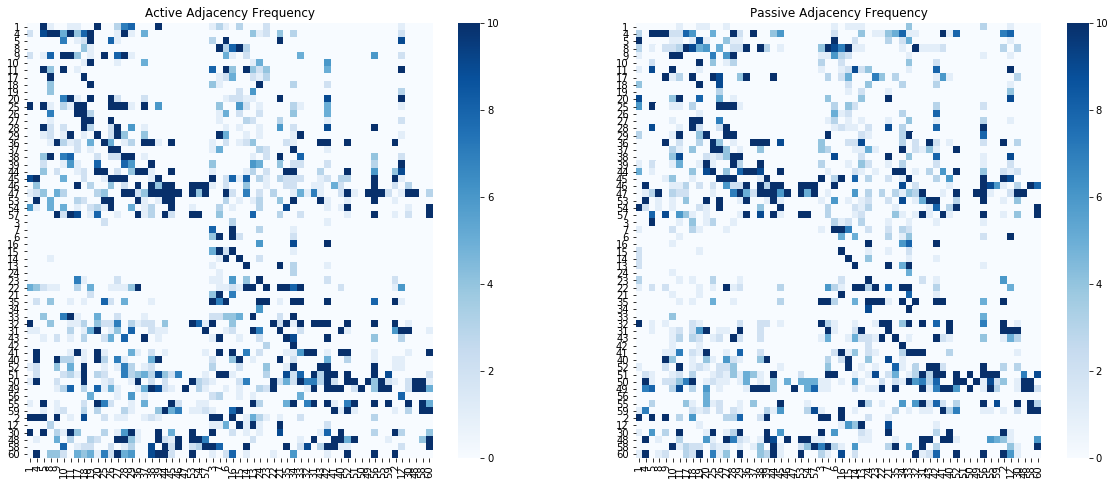

In [15]:
# Comparing the frequency table of the active vs passive
plt.rcParams["figure.figsize"] = (20, 8)
fig, axs = plt.subplots(1, 2)
sns.heatmap(graphs_active_freq, cmap='Blues', xticklabels=chs, yticklabels=chs, vmin=0, vmax=10, ax=axs[0])
axs[0].set_title('Active Adjacency Frequency')
sns.heatmap(graphs_passive_freq, cmap='Blues', xticklabels=chs, yticklabels=chs, vmin=0, vmax=10, ax=axs[1])
axs[1].set_title('Passive Adjacency Frequency')
        

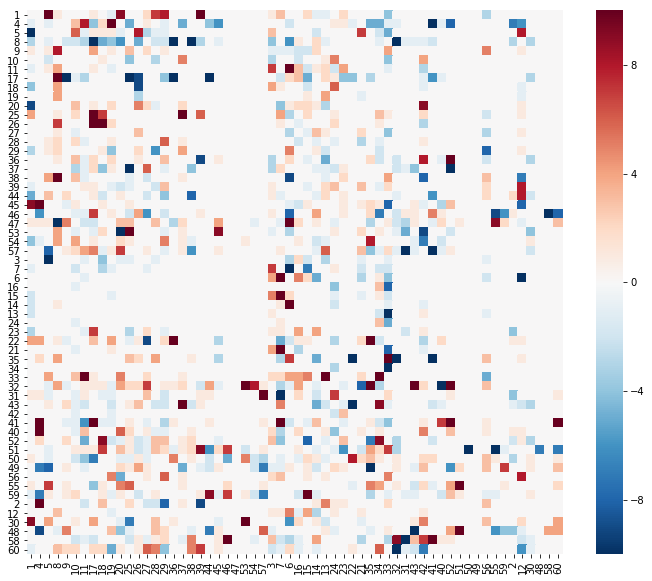

In [23]:
graph_diff = graphs_active_freq - graphs_passive_freq
plt.rcParams["figure.figsize"] = (12, 10)
sns.heatmap(graph_diff, cmap='RdBu_r', xticklabels=chs, yticklabels=chs, vmin=-10, vmax=10)

# Subject1

In [29]:
data_mat = sorted(glob.glob('../data/Subject1/*.fif'))
data_mat

['../data/Subject1/subj01_sess02_EEG_data_cube_oc-epo.fif',
 '../data/Subject1/subj01_sess03_EEG_data_cube_oc-epo.fif',
 '../data/Subject1/subj01_sess04_EEG_data_cube_oc-epo.fif',
 '../data/Subject1/subj01_sess05_EEG_data_cube_oc-epo.fif']

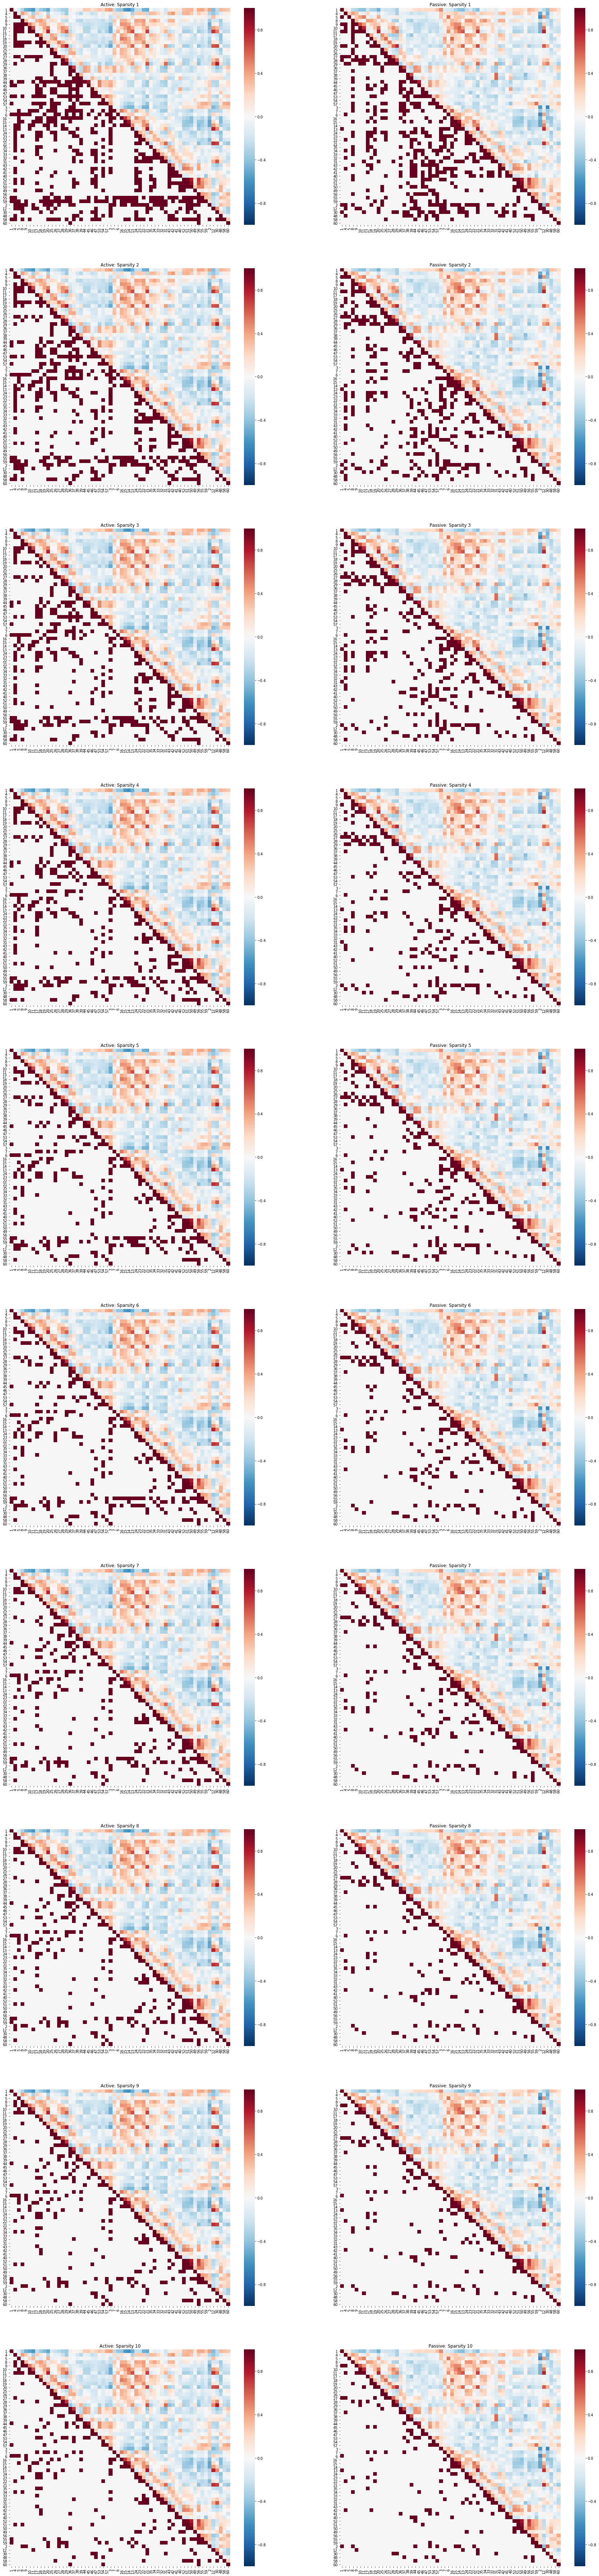

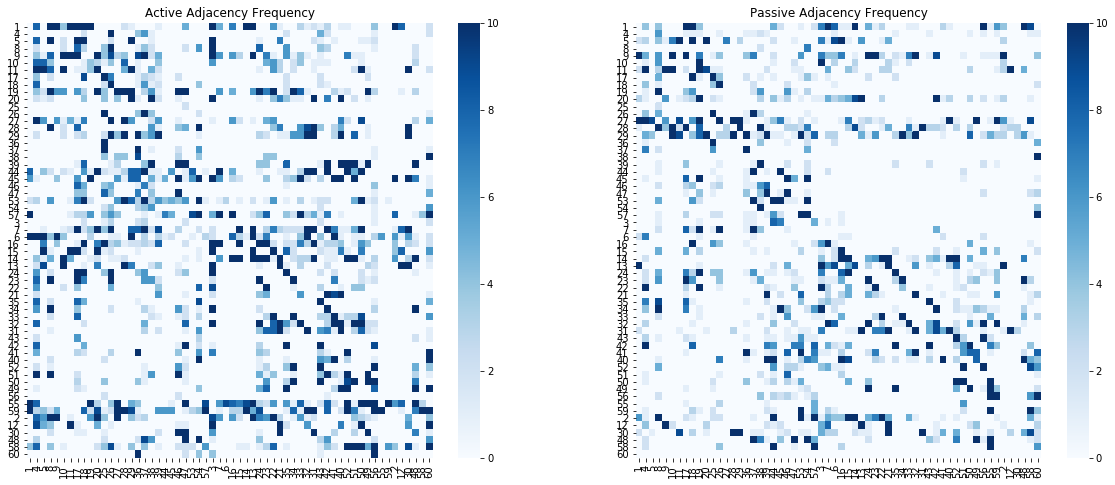

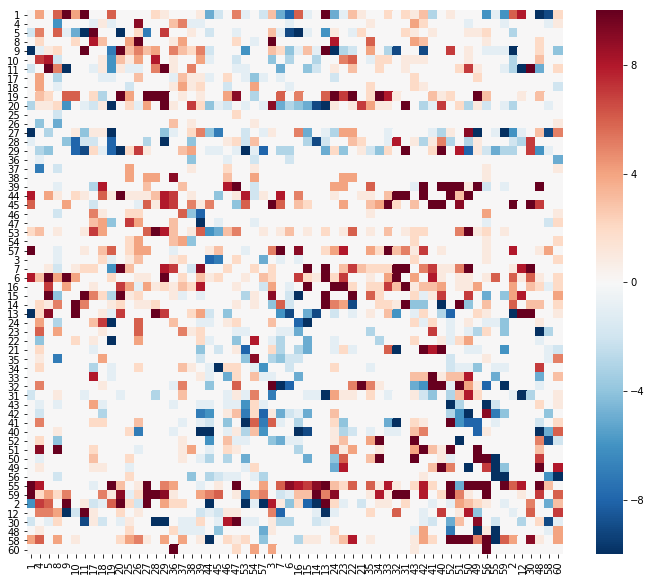

In [30]:
process(data_mat, "../data/graphs/subject2/")